### This notebook plots the impact loss (or gain) by equal shares in terms of proposed metrics - budget share, winning rate, cost representation and project representation; for projects grouped by cost-levels

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv

In [23]:
# use this code block to set column and row viewing size/width
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', 30)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199

pd.options.display.float_format = '{:.4f}'.format

In [24]:
# read the metadata csv
pbsummary_df = pd.read_csv('../metadata.csv', delimiter=';')
pbsummary_df = pbsummary_df.drop_duplicates()
pbsummary_df

pbsummary_aarau = pd.read_csv('../metadata_aarau.csv', delimiter=';')
pbsummary_df = pd.concat([pbsummary_df, pbsummary_aarau], ignore_index=True)

pbsummary_df['subunit'].fillna(value='all', inplace=True)

In [25]:
# Get election id and vote type, so we know better to segragate approval and score votings
pbsummary_with_vote_type = pbsummary_df[['election_id', 'vote_type']]
print(pbsummary_with_vote_type.head())

   election_id   vote_type
0            1  cumulative
1            2  cumulative
2            3  cumulative
3            4  cumulative
4            5  cumulative


In [26]:
# reading the projects CSV and loading to dataframe
pbprojects_df = pd.read_csv('../projects.csv', delimiter=';')
pbprojects_df.drop_duplicates(inplace=True)
print(pbprojects_df.shape)

pbprojects_aarau = pd.read_csv('../projects_aarau.csv', delimiter=';')
pbprojects_df = pd.concat([pbprojects_df, pbprojects_aarau], ignore_index=True)

# merge the column vote_type into pbprojects_df
pbprojects_df = pd.merge(pbprojects_df, pbsummary_with_vote_type, on='election_id', how='inner')
print(pbprojects_df.shape)

(19077, 21)
(19110, 22)


In [27]:
# Check for projects where cost of a given project is zero
print("Projects with zero costs: ", pbprojects_df[pbprojects_df['cost'] == 0])

# Currently returns a single project ID which has been commented as been removed by City Council
invalid_projects = pbprojects_df[pbprojects_df['cost'] == 0][['project_id','election_id']]

# Excluding that single project id by checking with particular election id and project id
valid_pbprojects_df = pbprojects_df[~(pbprojects_df['project_id'].isin(invalid_projects['project_id']) & (pbprojects_df['election_id'].isin(invalid_projects['election_id'])))]
print(pbprojects_df.shape)
print(valid_pbprojects_df.shape)

Projects with zero costs:       election_id country    unit           subunit  instance project_id  cost  \
893           72  Poland  Gdynia  Grabówek | large      2020          5     0   

     project_voters_count  votes  score category  \
893                  1511     18    NaN      NaN   

                                                        name  englishName  \
893  PROJECT WAS REMOVED BY THE CITY FOR VIOLATING THE RULES          NaN   

    target  total_budget  budget_percent  is_mes_winner  is_greedy_winner  \
893    NaN   295110.0000          0.0000           True              True   

     is_phragmen_winner  latitude  longitude vote_type  
893                True       NaN        NaN  approval  
(19110, 22)
(19109, 22)


In [28]:
# There are citywide elections (unit-level); i.e. subunit is na, for such records fill na columns with values for subunit as all
valid_pbprojects_df['subunit'].fillna(value='all', inplace=True)

# Cross checking for projects where by we have filled with subunit equalling the value 'all'
print(valid_pbprojects_df[valid_pbprojects_df['subunit'] == 'all'].shape)

(1928, 22)


C:\Users\scsmah\AppData\Local\Temp\ipykernel_28420\2651770478.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_pbprojects_df['subunit'].fillna(value='all', inplace=True)


In [29]:
# setting up vote_percent column
print(valid_pbprojects_df.shape)
valid_pb_projects_total_selections = valid_pbprojects_df.groupby(['election_id'])['votes'].sum().reset_index()
print(valid_pb_projects_total_selections.shape)
valid_pb_projects_total_selections.rename(columns={'votes': 'total_votes_selection'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(valid_pb_projects_total_selections, on='election_id', how='inner')
valid_pbprojects_df['vote_percent'] = round((valid_pbprojects_df['votes'] / valid_pbprojects_df['total_votes_selection'] * 100),3)
print(valid_pbprojects_df.shape)

(19109, 22)
(812, 2)
(19109, 24)


In [30]:
# There are citywide elections (unit-level); i.e. subunit is na, for such records fill na columns with values for subunit as all
valid_pbprojects_df['subunit'].fillna(value='all', inplace=True)

# Cross checking for projects where by we have filled with subunit equalling the value 'all'
print(valid_pbprojects_df[valid_pbprojects_df['subunit'] == 'all'].shape)
print("Valid PB projects are: ", valid_pbprojects_df.shape)

(1928, 24)
Valid PB projects are:  (19109, 24)


In [31]:
q1_df = valid_pbprojects_df.groupby(['election_id'])['cost'].quantile(0.25).reset_index()
q1_df.rename(columns={'cost': 'q1_cost'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(q1_df, on='election_id', how='inner')

q2_df = valid_pbprojects_df.groupby(['election_id'])['cost'].quantile(0.5).reset_index()
q2_df.rename(columns={'cost': 'q2_cost'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(q2_df, on='election_id', how='inner')

q3_df = valid_pbprojects_df.groupby(['election_id'])['cost'].quantile(0.75).reset_index()
q3_df.rename(columns={'cost': 'q3_cost'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(q3_df, on='election_id', how='inner')

q4_df = valid_pbprojects_df.groupby(['election_id'])['cost'].quantile(1).reset_index()
q4_df.rename(columns={'cost': 'q4_cost'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(q4_df, on='election_id', how='inner')

In [32]:
# total projects cost per election instance
total_projects_cost = valid_pbprojects_df.groupby(['election_id'])['cost'].sum().reset_index()
total_projects_cost.rename(columns={'cost': 'total_projects_cost'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(total_projects_cost, on='election_id', how='inner')
print(valid_pbprojects_df.shape)

total_projects_count = valid_pbprojects_df.groupby(['election_id'])['project_id'].count().reset_index()
total_projects_count.rename(columns={'project_id': 'total_projects_count'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(total_projects_count, on='election_id', how='inner')

# setting additional column for total project costs and count of winners for MES ang UG
# mes_winners_total_cost
mes_winners_total_cost = valid_pbprojects_df[valid_pbprojects_df['is_mes_winner'] == True].groupby(['election_id'])['cost'].sum().reset_index()
mes_winners_total_cost.rename(columns={'cost': 'mes_total_winners_cost'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(mes_winners_total_cost, on='election_id', how='inner')
print(valid_pbprojects_df.shape)

# only_mes_winners_total_cost
only_mes_winners_total_cost = valid_pbprojects_df[(valid_pbprojects_df['is_mes_winner'] == True) & (valid_pbprojects_df['is_greedy_winner'] == False)].groupby(['election_id'])['cost'].sum().reset_index()
only_mes_winners_total_cost.rename(columns={'cost': 'only_mes_total_winners_cost'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(only_mes_winners_total_cost, on='election_id', how='left')
print(valid_pbprojects_df.shape)

# greedy_winners_total_cost
greedy_total_winners_cost = valid_pbprojects_df[valid_pbprojects_df['is_greedy_winner'] == True].groupby(['election_id'])['cost'].sum().reset_index()
greedy_total_winners_cost.rename(columns={'cost': 'greedy_total_winners_cost'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(greedy_total_winners_cost, on='election_id', how='inner')
print(valid_pbprojects_df.shape)

# only_greedy_winners_total_cost
only_greedy_winners_total_cost = valid_pbprojects_df[(valid_pbprojects_df['is_mes_winner'] == False) & (valid_pbprojects_df['is_greedy_winner'] == True)].groupby(['election_id'])['cost'].sum().reset_index()
only_greedy_winners_total_cost.rename(columns={'cost': 'only_greedy_total_winners_cost'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(only_greedy_winners_total_cost, on='election_id', how='left')
print(valid_pbprojects_df.shape)

# mes winners total count
mes_total_winners_count = valid_pbprojects_df[(valid_pbprojects_df['is_mes_winner'] == True)].groupby(['election_id'])['project_id'].count().reset_index()
mes_total_winners_count.rename(columns={'project_id': 'mes_total_winners_count'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(mes_total_winners_count, on='election_id', how='inner')
print(valid_pbprojects_df.shape)

# only_mes_winners_total_count
only_mes_winners_total_count = valid_pbprojects_df[(valid_pbprojects_df['is_mes_winner'] == True) & (valid_pbprojects_df['is_greedy_winner'] == False)].groupby(['election_id'])['project_id'].count().reset_index()
only_mes_winners_total_count.rename(columns={'project_id': 'only_mes_total_winners_count'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(only_mes_winners_total_count, on='election_id', how='left')
print(valid_pbprojects_df.shape)

# greedy winners total count
greedy_total_winners_count = valid_pbprojects_df[(valid_pbprojects_df['is_greedy_winner'] == True)].groupby(['election_id'])['project_id'].count().reset_index()
greedy_total_winners_count.rename(columns={'project_id': 'greedy_total_winners_count'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(greedy_total_winners_count, on='election_id', how='inner')
print(valid_pbprojects_df.shape)

# only_greedy_winners_total_count
only_greedy_winners_total_count = valid_pbprojects_df[(valid_pbprojects_df['is_mes_winner'] == False) & (valid_pbprojects_df['is_greedy_winner'] == True)].groupby(['election_id'])['project_id'].count().reset_index()
only_greedy_winners_total_count.rename(columns={'project_id': 'only_greedy_total_winners_count'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(only_greedy_winners_total_count, on='election_id', how='left')
print(valid_pbprojects_df.shape)

(19109, 29)
(19109, 31)
(19109, 32)
(19109, 33)
(19109, 34)
(19109, 35)
(19109, 36)
(19109, 37)
(19109, 38)


In [33]:
# Initialize 4 different columns for labels
valid_pbprojects_df['in_first_quartile'] = 0
valid_pbprojects_df['in_second_quartile'] = 0
valid_pbprojects_df['in_third_quartile'] = 0
valid_pbprojects_df['in_fourth_quartile'] = 0

# Iterate through rows and update the new columns
for index, row in valid_pbprojects_df.iterrows():
    if row['cost'] <= row['q1_cost']:
        valid_pbprojects_df.at[index, 'in_first_quartile'] = 1
    elif row['cost'] > row['q1_cost'] and row['cost'] <= row['q2_cost']:
        valid_pbprojects_df.at[index, 'in_second_quartile'] = 1
    elif row['cost'] > row['q2_cost'] and row['cost'] <= row['q3_cost']:
        valid_pbprojects_df.at[index, 'in_third_quartile'] = 1
    else:
        valid_pbprojects_df.at[index, 'in_fourth_quartile'] = 1

In [34]:
cost_quartiles_set = ['first_quartile', 'second_quartile', 'third_quartile', 'fourth_quartile']

for cost_quartile in cost_quartiles_set:
    
    # total projects cost per election instance
    cost_quartile_total_projects_cost = valid_pbprojects_df[valid_pbprojects_df[f'in_{cost_quartile}'] == True].groupby(['election_id'])['cost'].sum().reset_index()
    cost_quartile_total_projects_cost.rename(columns={'cost': f'{cost_quartile}_total_projects_cost'}, inplace=True)
    valid_pbprojects_df = valid_pbprojects_df.merge(cost_quartile_total_projects_cost, on='election_id', how='left')

    # total projects count
    cost_quartile_total_projects_count = valid_pbprojects_df[valid_pbprojects_df[f'in_{cost_quartile}'] == True].groupby(['election_id'])['project_id'].count().reset_index()
    cost_quartile_total_projects_count.rename(columns={'project_id': f'{cost_quartile}_total_projects_count'}, inplace=True)
    valid_pbprojects_df = valid_pbprojects_df.merge(cost_quartile_total_projects_count, on='election_id', how='left')

    # setting additional column for total project costs and count of winners for MES ang UG
    # mes_winners_total_cost
    cost_quartile_mes_winners_total_cost = valid_pbprojects_df[(valid_pbprojects_df['is_mes_winner'] == True) & (valid_pbprojects_df[f'in_{cost_quartile}'] == True)].groupby(['election_id'])['cost'].sum().reset_index()
    cost_quartile_mes_winners_total_cost.rename(columns={'cost': f'{cost_quartile}_mes_winners_total_cost'}, inplace=True)
    valid_pbprojects_df = valid_pbprojects_df.merge(cost_quartile_mes_winners_total_cost, on='election_id', how='left')

    # only_mes_winners_total_cost
    cost_quartile_only_mes_winners_total_cost = valid_pbprojects_df[(valid_pbprojects_df['is_mes_winner'] == True) & (valid_pbprojects_df['is_greedy_winner'] == False) & (valid_pbprojects_df[f'in_{cost_quartile}'] == True)].groupby(['election_id'])['cost'].sum().reset_index()
    cost_quartile_only_mes_winners_total_cost.rename(columns={'cost': f'{cost_quartile}_only_mes_winners_total_cost'}, inplace=True)
    valid_pbprojects_df = valid_pbprojects_df.merge(cost_quartile_only_mes_winners_total_cost, on='election_id', how='left')

    # greedy_winners_total_cost
    cost_quartile_greedy_total_winners_cost = valid_pbprojects_df[(valid_pbprojects_df['is_greedy_winner'] == True) & (valid_pbprojects_df[f'in_{cost_quartile}'] == True)].groupby(['election_id'])['cost'].sum().reset_index()
    cost_quartile_greedy_total_winners_cost.rename(columns={'cost': f'{cost_quartile}_greedy_total_winners_cost'}, inplace=True)
    valid_pbprojects_df = valid_pbprojects_df.merge(cost_quartile_greedy_total_winners_cost, on='election_id', how='left')

    # only_greedy_winners_total_cost
    cost_quartile_only_greedy_winners_total_cost = valid_pbprojects_df[(valid_pbprojects_df['is_mes_winner'] == False) & (valid_pbprojects_df['is_greedy_winner'] == True) & (valid_pbprojects_df[f'in_{cost_quartile}'] == True)].groupby(['election_id'])['cost'].sum().reset_index()
    cost_quartile_only_greedy_winners_total_cost.rename(columns={'cost': f'{cost_quartile}_only_greedy_winners_total_cost'}, inplace=True)
    valid_pbprojects_df = valid_pbprojects_df.merge(cost_quartile_only_greedy_winners_total_cost, on='election_id', how='left')

    # mes winners total count
    cost_quartile_mes_total_winners_count = valid_pbprojects_df[(valid_pbprojects_df['is_mes_winner'] == True) & (valid_pbprojects_df[f'in_{cost_quartile}'] == True)].groupby(['election_id'])['project_id'].count().reset_index()
    cost_quartile_mes_total_winners_count.rename(columns={'project_id': f'{cost_quartile}_mes_total_winners_count'}, inplace=True)
    valid_pbprojects_df = valid_pbprojects_df.merge(cost_quartile_mes_total_winners_count, on='election_id', how='left')

    # only_mes_winners_total_count
    cost_quartile_only_mes_winners_total_count = valid_pbprojects_df[(valid_pbprojects_df['is_mes_winner'] == True) & (valid_pbprojects_df['is_greedy_winner'] == False) & (valid_pbprojects_df[f'in_{cost_quartile}'] == True)].groupby(['election_id'])['project_id'].count().reset_index()
    cost_quartile_only_mes_winners_total_count.rename(columns={'project_id': f'{cost_quartile}_only_mes_winners_total_count'}, inplace=True)
    valid_pbprojects_df = valid_pbprojects_df.merge(cost_quartile_only_mes_winners_total_count, on='election_id', how='left')

    # greedy winners total count
    cost_quartile_greedy_total_winners_count = valid_pbprojects_df[(valid_pbprojects_df['is_greedy_winner'] == True) & (valid_pbprojects_df[f'in_{cost_quartile}'] == True)].groupby(['election_id'])['project_id'].count().reset_index()
    cost_quartile_greedy_total_winners_count.rename(columns={'project_id': f'{cost_quartile}_greedy_total_winners_count'}, inplace=True)
    valid_pbprojects_df = valid_pbprojects_df.merge(cost_quartile_greedy_total_winners_count, on='election_id', how='left')

    # only_greedy_winners_total_count
    cost_quartile_only_greedy_winners_total_count = valid_pbprojects_df[(valid_pbprojects_df['is_mes_winner'] == False) & (valid_pbprojects_df['is_greedy_winner'] == True) & (valid_pbprojects_df[f'in_{cost_quartile}'] == True)].groupby(['election_id'])['project_id'].count().reset_index()
    cost_quartile_only_greedy_winners_total_count.rename(columns={'project_id': f'{cost_quartile}_only_greedy_winners_total_count'}, inplace=True)
    valid_pbprojects_df = valid_pbprojects_df.merge(cost_quartile_only_greedy_winners_total_count, on='election_id', how='left')

valid_pbprojects_df.shape

(19109, 82)

In [35]:
oneD_to_twoD_map = {
    0: [0,0],
    1: [0,1],
    2: [1,0],
    3: [1,1]
}

cost_quartile_title_map = {
    'first_quartile': 'Very Cheap',
    'second_quartile': 'Cheap',
    'third_quartile': 'Expensive',
    'fourth_quartile': 'Very Expensive'
}

## Metrics for Budget Share and Winning Rate

In [36]:
# relative winners based on cost quartiles
for cost_quartile in cost_quartiles_set:
    valid_pbprojects_df[f'greedy_relative_winners_cost_pct_{cost_quartile}'] = 1 * valid_pbprojects_df[f'{cost_quartile}_greedy_total_winners_cost'] / valid_pbprojects_df['greedy_total_winners_cost']
    valid_pbprojects_df[f'mes_relative_winners_cost_pct_{cost_quartile}'] = 1 * valid_pbprojects_df[f'{cost_quartile}_mes_winners_total_cost'] / valid_pbprojects_df['mes_total_winners_cost']
    valid_pbprojects_df[f'diff_greedy_mes_relative_winners_cost_pct_{cost_quartile}'] = valid_pbprojects_df[f'greedy_relative_winners_cost_pct_{cost_quartile}'] - valid_pbprojects_df[f'mes_relative_winners_cost_pct_{cost_quartile}']

    valid_pbprojects_df[f'greedy_relative_winners_count_pct_{cost_quartile}'] = 1 * valid_pbprojects_df[f'{cost_quartile}_greedy_total_winners_count'] / valid_pbprojects_df['greedy_total_winners_count']
    valid_pbprojects_df[f'mes_relative_winners_count_pct_{cost_quartile}'] = 1 * valid_pbprojects_df[f'{cost_quartile}_mes_total_winners_count'] / valid_pbprojects_df['mes_total_winners_count']
    valid_pbprojects_df[f'diff_greedy_mes_relative_winners_count_pct_{cost_quartile}'] = valid_pbprojects_df[f'greedy_relative_winners_count_pct_{cost_quartile}'] - valid_pbprojects_df[f'mes_relative_winners_count_pct_{cost_quartile}']
    
    valid_pbprojects_df[f'only_greedy_relative_winners_cost_pct_{cost_quartile}'] = 1 * valid_pbprojects_df[f'{cost_quartile}_only_greedy_winners_total_cost'] / valid_pbprojects_df['only_greedy_total_winners_cost']
    valid_pbprojects_df[f'only_mes_relative_winners_cost_pct_{cost_quartile}'] = 1 * valid_pbprojects_df[f'{cost_quartile}_only_mes_winners_total_cost'] / valid_pbprojects_df['only_mes_total_winners_cost']
    valid_pbprojects_df[f'diff_go_mo_relative_winners_cost_pct_{cost_quartile}'] = valid_pbprojects_df[f'only_greedy_relative_winners_cost_pct_{cost_quartile}'] - valid_pbprojects_df[f'only_mes_relative_winners_cost_pct_{cost_quartile}']

    valid_pbprojects_df[f'only_greedy_relative_winners_count_pct_{cost_quartile}'] = 1 * valid_pbprojects_df[f'{cost_quartile}_only_greedy_winners_total_count'] / valid_pbprojects_df[f'only_greedy_total_winners_count']
    valid_pbprojects_df[f'only_mes_relative_winners_count_pct_{cost_quartile}'] = 1 * valid_pbprojects_df[f'{cost_quartile}_only_mes_winners_total_count'] / valid_pbprojects_df[f'only_mes_total_winners_count']
    valid_pbprojects_df[f'diff_go_mo_relative_winners_count_pct_{cost_quartile}'] = valid_pbprojects_df[f'only_greedy_relative_winners_count_pct_{cost_quartile}'] - valid_pbprojects_df[f'only_mes_relative_winners_count_pct_{cost_quartile}']

# should increase by 48 cols
print(valid_pbprojects_df.shape)

(19109, 130)


In [37]:
# additional metrics for average; relative winners cost / number
for cost_quartile in cost_quartiles_set:
    valid_pbprojects_df[f'greedy_relative_winners_avg_cost_{cost_quartile}'] = valid_pbprojects_df[f'greedy_relative_winners_cost_pct_{cost_quartile}'] / valid_pbprojects_df[f'greedy_relative_winners_count_pct_{cost_quartile}']
    valid_pbprojects_df[f'mes_relative_winners_avg_cost_{cost_quartile}'] = valid_pbprojects_df[f'mes_relative_winners_cost_pct_{cost_quartile}'] / valid_pbprojects_df[f'mes_relative_winners_count_pct_{cost_quartile}']
    valid_pbprojects_df[f'diff_ug_mes_relative_winners_avg_cost_{cost_quartile}'] = valid_pbprojects_df[f'greedy_relative_winners_avg_cost_{cost_quartile}'] - valid_pbprojects_df[f'mes_relative_winners_avg_cost_{cost_quartile}'] 

    valid_pbprojects_df[f'only_greedy_relative_winners_avg_cost_{cost_quartile}'] = valid_pbprojects_df[f'only_greedy_relative_winners_cost_pct_{cost_quartile}'] / valid_pbprojects_df[f'only_greedy_relative_winners_count_pct_{cost_quartile}']
    valid_pbprojects_df[f'only_mes_relative_winners_avg_cost_{cost_quartile}'] = valid_pbprojects_df[f'only_mes_relative_winners_cost_pct_{cost_quartile}'] / valid_pbprojects_df[f'only_mes_relative_winners_count_pct_{cost_quartile}']
    valid_pbprojects_df[f'diff_go_mo_relative_winners_avg_cost_{cost_quartile}'] = valid_pbprojects_df[f'only_greedy_relative_winners_avg_cost_{cost_quartile}'] - valid_pbprojects_df[f'only_mes_relative_winners_avg_cost_{cost_quartile}']

In [38]:
cost_quartiles_color_map = {
    'first_quartile': '#a6611a',
    'second_quartile': '#dfc27d',
    'third_quartile': '#80cdc1',
    'fourth_quartile': '#018571'
}

warsaw_color_map = {
    '2020': '#98FB98',
    '2021': '#2E8B57',
    '2022': '#008000',
    '2023': '#004D00'
}

## Metrics for Cost and Project Representation

In [39]:
# metrics for calculation of relative proposals
for cost_quartile in cost_quartiles_set:
    valid_pbprojects_df[f'greedy_relative_proposals_cost_pct_{cost_quartile}'] = 1 * valid_pbprojects_df[f'{cost_quartile}_greedy_total_winners_cost'] / valid_pbprojects_df[f'{cost_quartile}_total_projects_cost']
    valid_pbprojects_df[f'mes_relative_proposals_cost_pct_{cost_quartile}'] = 1 * valid_pbprojects_df[f'{cost_quartile}_mes_winners_total_cost'] / valid_pbprojects_df[f'{cost_quartile}_total_projects_cost']
    valid_pbprojects_df[f'diff_greedy_mes_relative_proposals_cost_pct_{cost_quartile}'] = valid_pbprojects_df[f'greedy_relative_proposals_cost_pct_{cost_quartile}'] - valid_pbprojects_df[f'mes_relative_proposals_cost_pct_{cost_quartile}']
    
    valid_pbprojects_df[f'greedy_relative_proposals_count_pct_{cost_quartile}'] = 1 * valid_pbprojects_df[f'{cost_quartile}_greedy_total_winners_count'] / valid_pbprojects_df[f'{cost_quartile}_total_projects_count']
    valid_pbprojects_df[f'mes_relative_proposals_count_pct_{cost_quartile}'] = 1 * valid_pbprojects_df[f'{cost_quartile}_mes_total_winners_count'] / valid_pbprojects_df[f'{cost_quartile}_total_projects_count']
    valid_pbprojects_df[f'diff_greedy_mes_relative_proposals_count_pct_{cost_quartile}'] = valid_pbprojects_df[f'greedy_relative_proposals_count_pct_{cost_quartile}'] - valid_pbprojects_df[f'mes_relative_proposals_count_pct_{cost_quartile}']
    
    valid_pbprojects_df[f'only_greedy_relative_proposals_cost_pct_{cost_quartile}'] = 1 * valid_pbprojects_df[f'{cost_quartile}_only_greedy_winners_total_cost'] / valid_pbprojects_df[f'{cost_quartile}_total_projects_cost']
    valid_pbprojects_df[f'only_mes_relative_proposals_cost_pct_{cost_quartile}'] = 1 * valid_pbprojects_df[f'{cost_quartile}_only_mes_winners_total_cost'] / valid_pbprojects_df[f'{cost_quartile}_total_projects_cost']
    valid_pbprojects_df[f'diff_go_mo_relative_proposals_cost_pct_{cost_quartile}'] = valid_pbprojects_df[f'only_greedy_relative_proposals_cost_pct_{cost_quartile}'] - valid_pbprojects_df[f'only_mes_relative_proposals_cost_pct_{cost_quartile}']

    valid_pbprojects_df[f'only_greedy_relative_proposals_count_pct_{cost_quartile}'] = 1 * valid_pbprojects_df[f'{cost_quartile}_only_greedy_winners_total_count'] / valid_pbprojects_df[f'{cost_quartile}_total_projects_count']
    valid_pbprojects_df[f'only_mes_relative_proposals_count_pct_{cost_quartile}'] = 1 * valid_pbprojects_df[f'{cost_quartile}_only_mes_winners_total_count'] / valid_pbprojects_df[f'{cost_quartile}_total_projects_count']
    valid_pbprojects_df[f'diff_go_mo_relative_proposals_count_pct_{cost_quartile}'] = valid_pbprojects_df[f'only_greedy_relative_proposals_count_pct_{cost_quartile}'] - valid_pbprojects_df[f'only_mes_relative_proposals_count_pct_{cost_quartile}']

print("After adding new columns, shape should increase by 108 cols: ", valid_pbprojects_df.shape)

After adding new columns, shape should increase by 108 cols:  (19109, 202)


C:\Users\scsmah\AppData\Local\Temp\ipykernel_28420\1987452498.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  valid_pbprojects_df[f'diff_go_mo_relative_proposals_count_pct_{cost_quartile}'] = valid_pbprojects_df[f'only_greedy_relative_proposals_count_pct_{cost_quartile}'] - valid_pbprojects_df[f'only_mes_relative_proposals_count_pct_{cost_quartile}']
C:\Users\scsmah\AppData\Local\Temp\ipykernel_28420\1987452498.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  valid_pbprojects_df[f'greedy_relative_proposals_cost_pct_{cost

In [40]:
# additional metrics for average of relative proposals
for cost_quartile in cost_quartiles_set:
    valid_pbprojects_df[f'greedy_relative_proposals_avg_cost_{cost_quartile}'] = valid_pbprojects_df[f'greedy_relative_proposals_cost_pct_{cost_quartile}'] / valid_pbprojects_df[f'greedy_relative_proposals_count_pct_{cost_quartile}']
    valid_pbprojects_df[f'mes_relative_proposals_avg_cost_{cost_quartile}'] = valid_pbprojects_df[f'mes_relative_proposals_cost_pct_{cost_quartile}'] / valid_pbprojects_df[f'mes_relative_proposals_count_pct_{cost_quartile}']
    valid_pbprojects_df[f'only_greedy_relative_proposals_avg_cost_{cost_quartile}'] = valid_pbprojects_df[f'only_greedy_relative_proposals_cost_pct_{cost_quartile}'] / valid_pbprojects_df[f'only_greedy_relative_proposals_count_pct_{cost_quartile}']
    valid_pbprojects_df[f'only_mes_relative_proposals_avg_cost_{cost_quartile}'] = valid_pbprojects_df[f'only_mes_relative_proposals_cost_pct_{cost_quartile}'] / valid_pbprojects_df[f'only_mes_relative_proposals_count_pct_{cost_quartile}']

C:\Users\scsmah\AppData\Local\Temp\ipykernel_28420\1105207548.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  valid_pbprojects_df[f'greedy_relative_proposals_avg_cost_{cost_quartile}'] = valid_pbprojects_df[f'greedy_relative_proposals_cost_pct_{cost_quartile}'] / valid_pbprojects_df[f'greedy_relative_proposals_count_pct_{cost_quartile}']
C:\Users\scsmah\AppData\Local\Temp\ipykernel_28420\1105207548.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  valid_pbprojects_df[f'mes_relative_proposals_avg_cost_{cost_quartile}'] = va

### Plot for impact loss by equal shares for projects based on cost-levels; in terms of Budget Share, Winning Rate, Cost Representation and Project Representation

C:\Users\scsmah\AppData\Local\Temp\ipykernel_28420\82295682.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df.drop_duplicates(inplace=True)
C:\Users\scsmah\AppData\Local\Temp\ipykernel_28420\82295682.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df.drop_duplicates(inplace=True)
C:\Users\scsmah\AppData\Local\Temp\ipykernel_28420\82295682.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df.drop_duplicates(

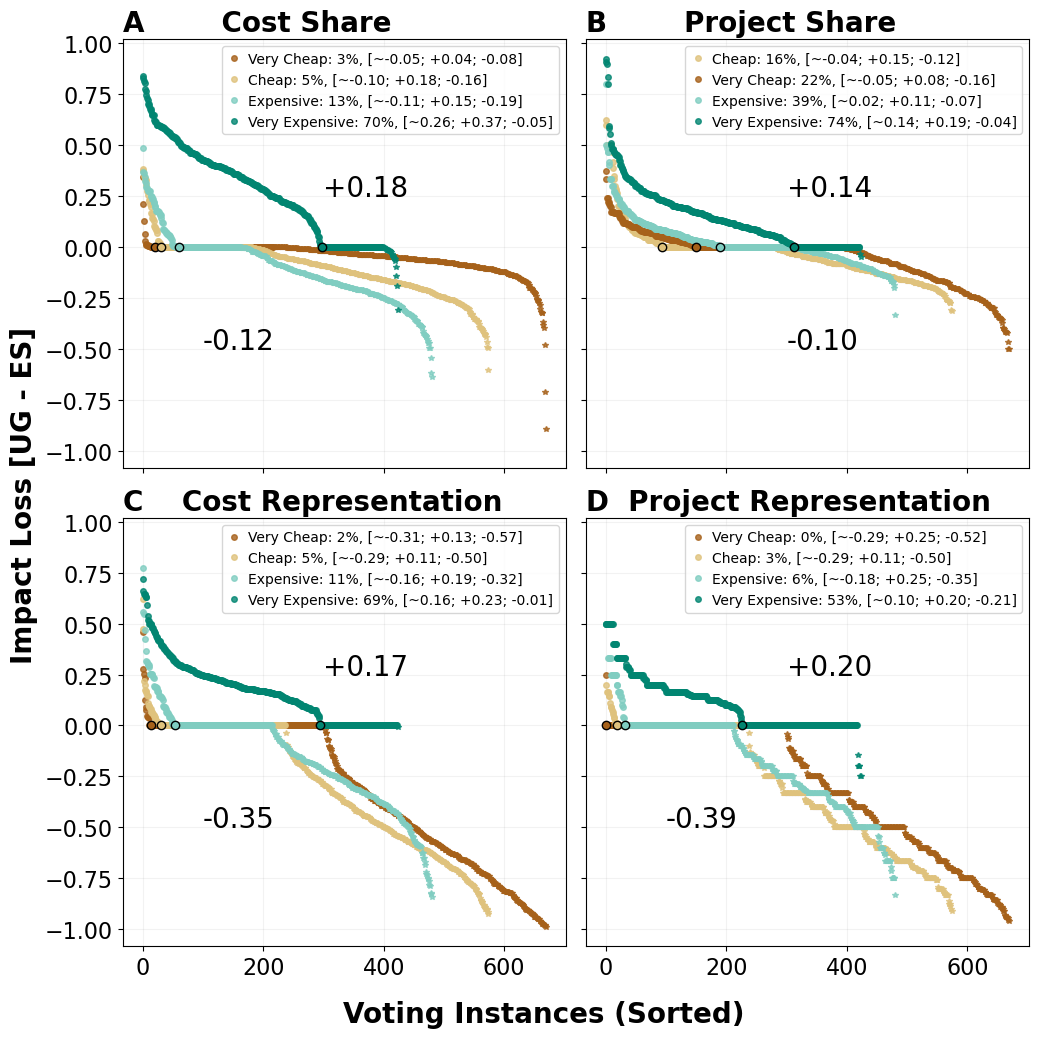

In [42]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

## first plot; budget share
bsflippingPoints = {
}

bs_num_election_map = {
}

# First loop through all categories to determine the order of flipping points
for idx, cost_quartile in enumerate(cost_quartiles_set):
    threshold_found = False
    cur_color = cost_quartiles_color_map[cost_quartile]
    temp_df = valid_pbprojects_df[['election_id', f'diff_greedy_mes_relative_winners_cost_pct_{cost_quartile}']]
    temp_df.drop_duplicates(inplace=True)
    bs_num_election_map[cost_quartile] = temp_df[f'diff_greedy_mes_relative_winners_cost_pct_{cost_quartile}'].count()
    
    diff_relative_winners_cost_pct_cost_quartile = temp_df[['election_id', f'diff_greedy_mes_relative_winners_cost_pct_{cost_quartile}']].sort_values(by=f'diff_greedy_mes_relative_winners_cost_pct_{cost_quartile}', ascending=False).reset_index()
    
    for i, row in diff_relative_winners_cost_pct_cost_quartile.iterrows():
        # Condition check for finding threshold
        if (threshold_found  == False) and (~(row[f'diff_greedy_mes_relative_winners_cost_pct_{cost_quartile}'] > 0)):
            bsflippingPoints[cost_quartile] = i
            threshold_found = True
            break

bsflippingPointsSorted = sorted(bsflippingPoints, key=bsflippingPoints.get)

overall_bs_positive = []
overall_bs_negative = []

# Second loop across all categories set to actually plot the lines in the flipping order
for idx, cost_quartile in enumerate(bsflippingPointsSorted):
    # additional metrics for percentage representation
    num_elections = temp_df.shape[0]
    flippingPointVal = bsflippingPoints[cost_quartile]
    flippingPointPct = 100 * flippingPointVal / bs_num_election_map[cost_quartile]

    cur_color = cost_quartiles_color_map[cost_quartile]
    
    temp_df = valid_pbprojects_df[['election_id', f'diff_greedy_mes_relative_winners_cost_pct_{cost_quartile}']]
    temp_df.drop_duplicates(inplace=True)
    diff_relative_winners_cost_pct_cost_quartile = temp_df[['election_id', f'diff_greedy_mes_relative_winners_cost_pct_{cost_quartile}']].sort_values(by=f'diff_greedy_mes_relative_winners_cost_pct_{cost_quartile}', ascending=False).reset_index()

    diff_relative_winners_cost_pct_cost_quartile_avg = np.mean(diff_relative_winners_cost_pct_cost_quartile[f'diff_greedy_mes_relative_winners_cost_pct_{cost_quartile}'])
    diff_relative_winners_cost_pct_cost_quartile_positive_avg = np.mean(diff_relative_winners_cost_pct_cost_quartile[diff_relative_winners_cost_pct_cost_quartile[f'diff_greedy_mes_relative_winners_cost_pct_{cost_quartile}'] > 0][f'diff_greedy_mes_relative_winners_cost_pct_{cost_quartile}'])
    diff_relative_winners_cost_pct_cost_quartile_negative_avg = np.mean(diff_relative_winners_cost_pct_cost_quartile[diff_relative_winners_cost_pct_cost_quartile[f'diff_greedy_mes_relative_winners_cost_pct_{cost_quartile}'] < 0][f'diff_greedy_mes_relative_winners_cost_pct_{cost_quartile}'])
    
    cur_cost_quartile_label = f'{cost_quartile_title_map[cost_quartile]}: {flippingPointPct:.0f}%, [~{diff_relative_winners_cost_pct_cost_quartile_avg:.2f}; +{diff_relative_winners_cost_pct_cost_quartile_positive_avg:.2f}; {diff_relative_winners_cost_pct_cost_quartile_negative_avg:.2f}]'

    overall_bs_positive.append(diff_relative_winners_cost_pct_cost_quartile_positive_avg)
    overall_bs_negative.append(diff_relative_winners_cost_pct_cost_quartile_negative_avg)
    
    for i, row in diff_relative_winners_cost_pct_cost_quartile.iterrows():
        # additional condition to any specific row data, just for labeling
        if i == 0:
            axes[0][0].plot(
                i, row[f'diff_greedy_mes_relative_winners_cost_pct_{cost_quartile}'],
                marker='o' if row[f'diff_greedy_mes_relative_winners_cost_pct_{cost_quartile}'] >= 0 else '*', 
                markerfacecolor= cur_color, 
                markeredgewidth=1, 
                markeredgecolor=cur_color if row[f'diff_greedy_mes_relative_winners_cost_pct_{cost_quartile}'] >= 0 else 'none', 
                label=cur_cost_quartile_label, 
                markersize=4, 
                alpha=0.8,
                linestyle='none'
            )
        else:
            axes[0][0].plot(
                    i, row[f'diff_greedy_mes_relative_winners_cost_pct_{cost_quartile}'], 
                    marker='o' if row[f'diff_greedy_mes_relative_winners_cost_pct_{cost_quartile}'] >= 0 else '*', 
                    markerfacecolor= cur_color, 
                    markeredgewidth=1, 
                    markeredgecolor=cur_color, 
                    markersize=4, 
                    alpha=0.8,
                    linestyle='none'
                )
            
# Third loop across to present the flipping point value on the outermost layer
for idx, cost_quartile in enumerate(bsflippingPointsSorted):
    cur_color = cost_quartiles_color_map[cost_quartile]
    temp_df = valid_pbprojects_df[['election_id', f'diff_greedy_mes_relative_winners_cost_pct_{cost_quartile}']]
    temp_df.drop_duplicates(inplace=True)
    diff_relative_winners_cost_pct_cost_quartile = temp_df[['election_id', f'diff_greedy_mes_relative_winners_cost_pct_{cost_quartile}']].sort_values(by=f'diff_greedy_mes_relative_winners_cost_pct_{cost_quartile}', ascending=False).reset_index()
    
    # additional variable to store flipping point value for the cost_quartile
    flippingPointVal = bsflippingPoints[cost_quartile]

    for i, row in diff_relative_winners_cost_pct_cost_quartile.iterrows():  
        # additional condition check to match the nth item for flipping point value
        if (i == flippingPointVal):
            
            # mark such observation with outer black edge color
            axes[0][0].plot(
                    i, row[f'diff_greedy_mes_relative_winners_cost_pct_{cost_quartile}'], 
                    marker='o',
                    markerfacecolor= cur_color, 
                    markeredgecolor='black', 
                )
            
overall_bs_positive_avg = np.mean(overall_bs_positive)
overall_bs_negative_avg = np.mean(overall_bs_negative)

axes[0][0].annotate(f'+{overall_bs_positive_avg:.2f}', xy=(0, 0), xytext=(300, 0.25), fontsize=20)
axes[0][0].annotate(f'{overall_bs_negative_avg:.2f}', xy=(0, 0), xytext=(100, -0.5), fontsize=20)

axes[0][0].legend(handlelength=1.0, handletextpad=0.5, fontsize=10)
axes[0][0].set_title("A        Cost Share", loc="left", fontsize=20, fontdict={'fontweight': 'bold'})
axes[0][0].grid(axis='both', which='major', color='gray', alpha=0.1)
axes[0][0].tick_params(axis='both', labelsize=16)

overall_bs_loss = 0.19
overall_bs_gain = -0.12
## end of first plot

## second plot; winning rate
wrflippingPoints = {
}

wr_num_election_map = {
}

# First loop through all categories to determine the order of flipping points
for idx, cost_quartile in enumerate(cost_quartiles_set):
    threshold_found = False
    cur_color = cost_quartiles_color_map[cost_quartile]
    temp_df = valid_pbprojects_df[['election_id', f'diff_greedy_mes_relative_winners_count_pct_{cost_quartile}']]
    temp_df.drop_duplicates(inplace=True)
    wr_num_election_map[cost_quartile] = temp_df[f'diff_greedy_mes_relative_winners_count_pct_{cost_quartile}'].count()
    diff_relative_winners_count_pct_cost_quartile = temp_df[['election_id', f'diff_greedy_mes_relative_winners_count_pct_{cost_quartile}']].sort_values(by=f'diff_greedy_mes_relative_winners_count_pct_{cost_quartile}', ascending=False).reset_index()
    
    for i, row in diff_relative_winners_count_pct_cost_quartile.iterrows():
        # Condition check for finding threshold
        if (threshold_found  == False) and (~(row[f'diff_greedy_mes_relative_winners_count_pct_{cost_quartile}'] > 0)):
            wrflippingPoints[cost_quartile] = i
            threshold_found = True
            break

wrflippingPointsSorted = sorted(wrflippingPoints, key=wrflippingPoints.get)

overall_wr_positive = []
overall_wr_negative = []

# Second loop across all categories set to actually plot the lines in the flipping order
for idx, cost_quartile in enumerate(wrflippingPointsSorted):
    # additional metrics for percentage representation
    num_elections = temp_df.shape[0]
    flippingPointVal = wrflippingPoints[cost_quartile]
    flippingPointPct = 100 * flippingPointVal / wr_num_election_map[cost_quartile]

    cur_color = cost_quartiles_color_map[cost_quartile]
    
    temp_df = valid_pbprojects_df[['election_id', f'diff_greedy_mes_relative_winners_count_pct_{cost_quartile}']]
    temp_df.drop_duplicates(inplace=True)
    
    diff_relative_winners_count_pct_cost_quartile = temp_df[['election_id', f'diff_greedy_mes_relative_winners_count_pct_{cost_quartile}']].sort_values(by=f'diff_greedy_mes_relative_winners_count_pct_{cost_quartile}', ascending=False).reset_index()
    
    diff_relative_winners_count_pct_cost_quartile_avg = np.mean(diff_relative_winners_count_pct_cost_quartile[f'diff_greedy_mes_relative_winners_count_pct_{cost_quartile}'])
    diff_relative_winners_count_pct_cost_quartile_positive_avg = np.mean(diff_relative_winners_count_pct_cost_quartile[diff_relative_winners_count_pct_cost_quartile[f'diff_greedy_mes_relative_winners_count_pct_{cost_quartile}'] > 0][f'diff_greedy_mes_relative_winners_count_pct_{cost_quartile}'])
    diff_relative_winners_count_pct_cost_quartile_negative_avg = np.mean(diff_relative_winners_count_pct_cost_quartile[diff_relative_winners_count_pct_cost_quartile[f'diff_greedy_mes_relative_winners_count_pct_{cost_quartile}'] < 0][f'diff_greedy_mes_relative_winners_count_pct_{cost_quartile}'])

    overall_wr_positive.append(diff_relative_winners_count_pct_cost_quartile_positive_avg)
    overall_wr_negative.append(diff_relative_winners_count_pct_cost_quartile_negative_avg)

    cur_cost_quartile_label = f'{cost_quartile_title_map[cost_quartile]}: {flippingPointPct:.0f}%, [~{diff_relative_winners_count_pct_cost_quartile_avg:.2f}; +{diff_relative_winners_count_pct_cost_quartile_positive_avg:.2f}; {diff_relative_winners_count_pct_cost_quartile_negative_avg:.2f}]'

    for i, row in diff_relative_winners_count_pct_cost_quartile.iterrows():
        # additional condition to any specific row data, just for labeling
        if i == 0:
            axes[0][1].plot(
                i, row[f'diff_greedy_mes_relative_winners_count_pct_{cost_quartile}'],
                marker='o' if row[f'diff_greedy_mes_relative_winners_count_pct_{cost_quartile}'] >= 0 else '*', 
                markerfacecolor= cur_color, 
                markeredgewidth=1, 
                markeredgecolor=cur_color if row[f'diff_greedy_mes_relative_winners_count_pct_{cost_quartile}'] >= 0 else 'none', 
                label=cur_cost_quartile_label, 
                markersize=4, 
                alpha=0.8,
                linestyle='none'
            )
        else:
            axes[0][1].plot(
                    i, row[f'diff_greedy_mes_relative_winners_count_pct_{cost_quartile}'], 
                    marker='o' if row[f'diff_greedy_mes_relative_winners_count_pct_{cost_quartile}'] >= 0 else '*', 
                    markerfacecolor= cur_color, 
                    markeredgewidth=1, 
                    markeredgecolor=cur_color, 
                    markersize=4, 
                    alpha=0.8,
                    linestyle='none'
                )
            
# Third loop across to present the flipping point value on the outermost layer
for idx, cost_quartile in enumerate(wrflippingPointsSorted):
    cur_color = cost_quartiles_color_map[cost_quartile]
    temp_df = valid_pbprojects_df[['election_id', f'diff_greedy_mes_relative_winners_count_pct_{cost_quartile}']]
    temp_df.drop_duplicates(inplace=True)
    diff_relative_winners_count_pct_cost_quartile = temp_df[['election_id', f'diff_greedy_mes_relative_winners_count_pct_{cost_quartile}']].sort_values(by=f'diff_greedy_mes_relative_winners_count_pct_{cost_quartile}', ascending=False).reset_index()
    
    # additional variable to store flipping point value for the cost_quartile
    flippingPointVal = wrflippingPoints[cost_quartile]

    for i, row in diff_relative_winners_count_pct_cost_quartile.iterrows():  
        # additional condition check to match the nth item for flipping point value
        if (i == flippingPointVal):
            
            # mark such observation with outer black edge color
            axes[0][1].plot(
                    i, row[f'diff_greedy_mes_relative_winners_count_pct_{cost_quartile}'], 
                    marker='o',
                    markerfacecolor= cur_color, 
                    markeredgecolor='black', 
                )
            
overall_wr_positive_avg = np.mean(overall_wr_positive)
overall_wr_negative_avg = np.mean(overall_wr_negative)

axes[0][1].annotate(f'+{overall_wr_positive_avg:.2f}', xy=(0, 0), xytext=(300, 0.25), fontsize=20)
axes[0][1].annotate(f'{overall_wr_negative_avg:.2f}', xy=(0, 0), xytext=(300, -0.5), fontsize=20)

axes[0][1].legend(handlelength=1.0, handletextpad=0.5, fontsize=10)
axes[0][1].set_title("B        Project Share", loc="left", fontsize=20, fontdict={'fontweight': 'bold'})
axes[0][1].grid(axis='both', which='major', color='gray', alpha=0.1)
axes[0][1].tick_params(axis='both', labelsize=16)
## end of second plot

## third plot; cost representation
crflippingPoints = {
}

cr_num_election_map = {
}

# First loop through all categories to determine the order of flipping points
for idx, cost_quartile in enumerate(cost_quartiles_set):
    threshold_found = False
    cur_color = cost_quartiles_color_map[cost_quartile]
    temp_df = valid_pbprojects_df[['election_id', f'diff_greedy_mes_relative_proposals_cost_pct_{cost_quartile}']]
    temp_df.drop_duplicates(inplace=True)
    cr_num_election_map[cost_quartile] = temp_df[f'diff_greedy_mes_relative_proposals_cost_pct_{cost_quartile}'].count()
    diff_relative_proposals_cost_pct_cost_quartile = temp_df[['election_id', f'diff_greedy_mes_relative_proposals_cost_pct_{cost_quartile}']].sort_values(by=f'diff_greedy_mes_relative_proposals_cost_pct_{cost_quartile}', ascending=False).reset_index()
    
    for i, row in diff_relative_proposals_cost_pct_cost_quartile.iterrows():
        # Condition check for finding threshold
        if (threshold_found  == False) and (~(row[f'diff_greedy_mes_relative_proposals_cost_pct_{cost_quartile}'] > 0)):
            crflippingPoints[cost_quartile] = i
            threshold_found = True
            break

crflippingPointsSorted = sorted(crflippingPoints, key=crflippingPoints.get)

overall_cr_positive = []
overall_cr_negative = []

# Second loop across all categories set to actually plot the lines in the flipping order
for idx, cost_quartile in enumerate(crflippingPointsSorted):
    # additional metrics for percentage representation
    num_elections = temp_df.shape[0]
    flippingPointVal = crflippingPoints[cost_quartile]
    flippingPointPct = 100 * flippingPointVal / cr_num_election_map[cost_quartile]

    cur_color = cost_quartiles_color_map[cost_quartile]
    
    temp_df = valid_pbprojects_df[['election_id', f'diff_greedy_mes_relative_proposals_cost_pct_{cost_quartile}']]
    temp_df.drop_duplicates(inplace=True)
    
    diff_relative_proposals_cost_pct_cost_quartile = temp_df[['election_id', f'diff_greedy_mes_relative_proposals_cost_pct_{cost_quartile}']].sort_values(by=f'diff_greedy_mes_relative_proposals_cost_pct_{cost_quartile}', ascending=False).reset_index()

    diff_relative_proposals_cost_pct_cost_quartile_avg = np.mean(diff_relative_proposals_cost_pct_cost_quartile[f'diff_greedy_mes_relative_proposals_cost_pct_{cost_quartile}'])
    diff_relative_proposals_cost_pct_cost_quartile_positive_avg = np.mean(diff_relative_proposals_cost_pct_cost_quartile[diff_relative_proposals_cost_pct_cost_quartile[f'diff_greedy_mes_relative_proposals_cost_pct_{cost_quartile}'] > 0][f'diff_greedy_mes_relative_proposals_cost_pct_{cost_quartile}'])
    diff_relative_proposals_cost_pct_cost_quartile_negative_avg = np.mean(diff_relative_proposals_cost_pct_cost_quartile[diff_relative_proposals_cost_pct_cost_quartile[f'diff_greedy_mes_relative_proposals_cost_pct_{cost_quartile}'] < 0][f'diff_greedy_mes_relative_proposals_cost_pct_{cost_quartile}'])

    overall_cr_positive.append(diff_relative_proposals_cost_pct_cost_quartile_positive_avg)
    overall_cr_negative.append(diff_relative_proposals_cost_pct_cost_quartile_negative_avg)

    cur_cost_quartile_label = f'{cost_quartile_title_map[cost_quartile]}: {flippingPointPct:.0f}%, [~{diff_relative_proposals_cost_pct_cost_quartile_avg:.2f}; +{diff_relative_proposals_cost_pct_cost_quartile_positive_avg:.2f}; {diff_relative_proposals_cost_pct_cost_quartile_negative_avg:.2f}]'

    for i, row in diff_relative_proposals_cost_pct_cost_quartile.iterrows():
        # additional condition to any specific row data, just for labeling
        if i == 0:
            axes[1][0].plot(
                i, row[f'diff_greedy_mes_relative_proposals_cost_pct_{cost_quartile}'],
                marker='o' if row[f'diff_greedy_mes_relative_proposals_cost_pct_{cost_quartile}'] >= 0 else '*', 
                markerfacecolor= cur_color, 
                markeredgewidth=1, 
                markeredgecolor=cur_color if row[f'diff_greedy_mes_relative_proposals_cost_pct_{cost_quartile}'] >= 0 else 'none', 
                label=cur_cost_quartile_label, 
                markersize=4, 
                alpha=0.8,
                linestyle='none'
            )
        else:
            axes[1][0].plot(
                    i, row[f'diff_greedy_mes_relative_proposals_cost_pct_{cost_quartile}'], 
                    marker='o' if row[f'diff_greedy_mes_relative_proposals_cost_pct_{cost_quartile}'] >= 0 else '*', 
                    markerfacecolor= cur_color, 
                    markeredgewidth=1, 
                    markeredgecolor=cur_color, 
                    markersize=4, 
                    alpha=0.8,
                    linestyle='none'
                )
            
# Third loop across to present the flipping point value on the outermost layer
for idx, cost_quartile in enumerate(crflippingPointsSorted):
    cur_color = cost_quartiles_color_map[cost_quartile]
    temp_df = valid_pbprojects_df[['election_id', f'diff_greedy_mes_relative_proposals_cost_pct_{cost_quartile}']]
    temp_df.drop_duplicates(inplace=True)
    diff_relative_proposals_cost_pct_cost_quartile = temp_df[['election_id', f'diff_greedy_mes_relative_proposals_cost_pct_{cost_quartile}']].sort_values(by=f'diff_greedy_mes_relative_proposals_cost_pct_{cost_quartile}', ascending=False).reset_index()
    
    # additional variable to store flipping point value for the cost_quartile
    flippingPointVal = crflippingPoints[cost_quartile]

    for i, row in diff_relative_proposals_cost_pct_cost_quartile.iterrows():  
        # additional condition check to match the nth item for flipping point value
        if (i == flippingPointVal):
            
            # mark such observation with outer black edge color
            axes[1][0].plot(
                    i, row[f'diff_greedy_mes_relative_proposals_cost_pct_{cost_quartile}'], 
                    marker='o',
                    markerfacecolor= cur_color, 
                    markeredgecolor='black', 
                )
            
overall_cr_positive_avg = np.mean(overall_cr_positive)
overall_cr_negative_avg = np.mean(overall_cr_negative)

axes[1][0].annotate(f'+{overall_cr_positive_avg:.2f}', xy=(0, 0), xytext=(300, 0.25), fontsize=20)
axes[1][0].annotate(f'{overall_cr_negative_avg:.2f}', xy=(0, 0), xytext=(100, -0.5), fontsize=20)

axes[1][0].legend(handlelength=1.0, handletextpad=0.5, fontsize=10)
axes[1][0].set_title("C    Cost Representation", loc="left", fontsize=20, fontdict={'fontweight': 'bold'})
axes[1][0].grid(axis='both', which='major', color='gray', alpha=0.1)
axes[1][0].tick_params(axis='both', labelsize=16)
## end of third plot

## fourth plot; project representation
prflippingPoints = {
}

pr_num_election_map = {
}

# First loop through all categories to determine the order of flipping points
for idx, cost_quartile in enumerate(cost_quartiles_set):
    threshold_found = False
    cur_color = cost_quartiles_color_map[cost_quartile]
    temp_df = valid_pbprojects_df[['election_id', f'diff_greedy_mes_relative_proposals_count_pct_{cost_quartile}']]
    temp_df.drop_duplicates(inplace=True)
    pr_num_election_map[cost_quartile] = temp_df[f'diff_greedy_mes_relative_proposals_count_pct_{cost_quartile}'].count()
    diff_relative_proposals_count_pct_cost_quartile = temp_df[['election_id', f'diff_greedy_mes_relative_proposals_count_pct_{cost_quartile}']].sort_values(by=f'diff_greedy_mes_relative_proposals_count_pct_{cost_quartile}', ascending=False).reset_index()
    
    for i, row in diff_relative_proposals_count_pct_cost_quartile.iterrows():
        # Condition check for finding threshold
        if (threshold_found  == False) and (~(row[f'diff_greedy_mes_relative_proposals_count_pct_{cost_quartile}'] > 0)):
            prflippingPoints[cost_quartile] = i
            threshold_found = True
            break

prflippingPointsSorted = sorted(prflippingPoints, key=prflippingPoints.get)

overall_pr_positive = []
overall_pr_negative = []

# Second loop across all categories set to actually plot the lines in the flipping order
for idx, cost_quartile in enumerate(prflippingPointsSorted):
    # additional metrics for percentage representation
    num_elections = temp_df.shape[0]
    flippingPointVal = prflippingPoints[cost_quartile]
    flippingPointPct = 100 * flippingPointVal / pr_num_election_map[cost_quartile]

    cur_color = cost_quartiles_color_map[cost_quartile]
    
    temp_df = valid_pbprojects_df[['election_id', f'diff_greedy_mes_relative_proposals_count_pct_{cost_quartile}']]
    temp_df.drop_duplicates(inplace=True)
    
    diff_relative_proposals_count_pct_cost_quartile = temp_df[['election_id', f'diff_greedy_mes_relative_proposals_count_pct_{cost_quartile}']].sort_values(by=f'diff_greedy_mes_relative_proposals_count_pct_{cost_quartile}', ascending=False).reset_index()
    
    diff_relative_proposals_count_pct_cost_quartile_avg = np.mean(diff_relative_proposals_count_pct_cost_quartile[f'diff_greedy_mes_relative_proposals_count_pct_{cost_quartile}'])
    diff_relative_proposals_count_pct_cost_quartile_positive_avg = np.mean(diff_relative_proposals_count_pct_cost_quartile[diff_relative_proposals_count_pct_cost_quartile[f'diff_greedy_mes_relative_proposals_count_pct_{cost_quartile}'] > 0][f'diff_greedy_mes_relative_proposals_count_pct_{cost_quartile}'])
    diff_relative_proposals_count_pct_cost_quartile_negative_avg = np.mean(diff_relative_proposals_count_pct_cost_quartile[diff_relative_proposals_count_pct_cost_quartile[f'diff_greedy_mes_relative_proposals_count_pct_{cost_quartile}'] < 0][f'diff_greedy_mes_relative_proposals_count_pct_{cost_quartile}'])

    overall_pr_positive.append(diff_relative_proposals_count_pct_cost_quartile_positive_avg)
    overall_pr_negative.append(diff_relative_proposals_count_pct_cost_quartile_negative_avg)

    cur_cost_quartile_label = f'{cost_quartile_title_map[cost_quartile]}: {flippingPointPct:.0f}%, [~{diff_relative_proposals_count_pct_cost_quartile_avg:.2f}; +{diff_relative_proposals_count_pct_cost_quartile_positive_avg:.2f}; {diff_relative_proposals_count_pct_cost_quartile_negative_avg:.2f}]'

    for i, row in diff_relative_proposals_count_pct_cost_quartile.iterrows():
        # additional condition to any specific row data, just for labeling
        if i == 0:
            axes[1][1].plot(
                i, row[f'diff_greedy_mes_relative_proposals_count_pct_{cost_quartile}'],
                marker='o' if row[f'diff_greedy_mes_relative_proposals_count_pct_{cost_quartile}'] >= 0 else '*', 
                markerfacecolor= cur_color, 
                markeredgewidth=1, 
                markeredgecolor=cur_color if row[f'diff_greedy_mes_relative_proposals_count_pct_{cost_quartile}'] >= 0 else 'none', 
                label=cur_cost_quartile_label, 
                markersize=4, 
                alpha=0.8,
                linestyle='none'
            )
        else:
            axes[1][1].plot(
                    i, row[f'diff_greedy_mes_relative_proposals_count_pct_{cost_quartile}'], 
                    marker='o' if row[f'diff_greedy_mes_relative_proposals_count_pct_{cost_quartile}'] >= 0 else '*', 
                    markerfacecolor= cur_color, 
                    markeredgewidth=1, 
                    markeredgecolor=cur_color, 
                    markersize=4, 
                    alpha=0.8,
                    linestyle='none'
                )
            
# Third loop across to present the flipping point value on the outermost layer
for idx, cost_quartile in enumerate(prflippingPointsSorted):
    cur_color = cost_quartiles_color_map[cost_quartile]
    temp_df = valid_pbprojects_df[['election_id', f'diff_greedy_mes_relative_proposals_count_pct_{cost_quartile}']]
    temp_df.drop_duplicates(inplace=True)
    diff_relative_proposals_count_pct_cost_quartile = temp_df[['election_id', f'diff_greedy_mes_relative_proposals_count_pct_{cost_quartile}']].sort_values(by=f'diff_greedy_mes_relative_proposals_count_pct_{cost_quartile}', ascending=False).reset_index()
    
    # additional variable to store flipping point value for the cost_quartile
    flippingPointVal = prflippingPoints[cost_quartile]

    for i, row in diff_relative_proposals_count_pct_cost_quartile.iterrows():  
        # additional condition check to match the nth item for flipping point value
        if (i == flippingPointVal):
            
            # mark such observation with outer black edge color
            axes[1][1].plot(
                    i, row[f'diff_greedy_mes_relative_proposals_count_pct_{cost_quartile}'], 
                    marker='o',
                    markerfacecolor= cur_color, 
                    markeredgecolor='black', 
                )
            
overall_pr_positive_avg = np.mean(overall_pr_positive)
overall_pr_negative_avg = np.mean(overall_pr_negative)

axes[1][1].annotate(f'+{overall_pr_positive_avg:.2f}', xy=(0, 0), xytext=(300, 0.25), fontsize=20)
axes[1][1].annotate(f'{overall_pr_negative_avg:.2f}', xy=(0, 0), xytext=(100, -0.5), fontsize=20)

axes[1][1].legend(handlelength=1.0, handletextpad=0.5, fontsize=10)
axes[1][1].set_title("D  Project Representation", loc="left", fontsize=20, fontdict={'fontweight': 'bold'})
axes[1][1].grid(axis='both', which='major', color='gray', alpha=0.1)
axes[1][1].tick_params(axis='both', labelsize=16)
## end of fourth plot

fig.text(0.5, -0.02, 'Voting Instances (Sorted)', fontsize=20, ha='center', va='center', fontweight='bold')
fig.text(-0.02, 0.5, 'Impact Loss [UG - ES]', ha='center', va='center', rotation='vertical', fontsize=20, fontweight='bold')

plt.tight_layout()
plt.show()